# This file is used to train

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from sc_model import SC_LSTM as Model

# Device init

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Mon Jul 10 06:40:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0               27W /  N/A|   1049MiB /  4096MiB |     56%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = 'cpu'

## Loading the data

In [4]:
from Data.PreprocessorOfGeneratedData import Preprocessor

preproc = Preprocessor()

data = pd.read_csv('../Data/schedule_gen.csv')
data

,Label Number,Duration,Importance,Start Time,Date
0,0,20,0,10:13,10/07/2023
1,1,80,1,12:13,10/07/2023
2,1,40,2,14:53,10/07/2023
3,3,170,2,17:13,10/07/2023
4,1,30,1,20:53,10/07/2023
...,...,...,...,...,...
5386,2,70,0,15:25,16/09/2025
5387,0,20,0,17:00,16/09/2025
5388,1,80,1,18:45,16/09/2025
5389,0,30,1,21:20,16/09/2025


In [5]:
input_data, type_vector, output_data = preproc.preprocess('../Data/schedule_gen.csv')
input_data = np.array(input_data, dtype=np.float64)
pd.DataFrame(input_data)
# input_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,0.090909,0.00,0.002778,0.000012,1.000000,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
1,0.0,1.0,0.0,0.0,0.454545,0.25,0.086111,0.000376,1.000000,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
2,0.0,0.0,0.0,0.0,0.212121,0.50,0.197222,0.000861,1.000000,0.000000,0.000000,1.000000,0.0,1.000000e+00
3,0.0,0.0,0.0,0.0,1.000000,0.50,0.294444,0.001285,0.999999,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
4,0.0,0.0,0.0,0.0,0.151515,0.25,0.447222,0.001951,0.999998,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,0.0,0.0,0.0,0.0,0.393939,0.00,0.311111,0.001357,0.999999,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5387,0.0,0.0,0.0,0.0,0.090909,0.00,0.377083,0.001645,0.999999,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5388,0.0,0.0,0.0,0.0,0.454545,0.25,0.450000,0.001963,0.999998,0.000000,0.000000,1.000000,0.0,1.000000e+00
5389,0.0,0.0,0.0,0.0,0.151515,0.25,0.557639,0.002433,0.999997,0.000000,0.000000,1.000000,0.0,1.000000e+00


In [6]:
# Make the data positive
output_data = np.abs(np.array(output_data, dtype=np.float64))
pd.DataFrame(output_data)

,0,1,2
0,0.002778,0.013889,0.000000
1,0.086111,0.065972,0.010417
2,0.197222,0.027778,0.000000
3,0.294444,0.118056,0.000000
4,0.447222,0.020833,0.000000
...,...,...,...
5386,0.311111,0.048611,0.000000
5387,0.377083,0.013889,0.000000
5388,0.450000,0.055556,0.000000
5389,0.557639,0.020833,0.000000


## Creating the dataset

In [7]:
from torch.utils.data import Dataset, DataLoader

class ScheduleDataset(Dataset):
    def __init__(self, input_data, type_vector, output_vector, task_types='all', transform=None):
        if task_types == 'all':
            self.input_data = input_data
            self.type_vector = type_vector
            self.output_vector = output_vector
        elif task_types == 'resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        elif task_types == 'non-resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "non-resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        else:
            raise ValueError("task_types must be 'all', 'resched', or 'non-resched'")
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.type_vector[idx], self.output_vector[idx]

In [8]:
resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='resched')
non_resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='non-resched')
all_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='all')

print(f"Resched dataset size: {len(resched_dataset)}\n"
      f"Non-resched dataset size: {len(non_resched_dataset)}\n"
      f"All dataset size: {len(all_dataset)}")

Resched dataset size: 4293
Non-resched dataset size: 1098
All dataset size: 5391


## Create dataloaders

In [9]:
batch_size = 1
# resched_dataset_size = len(resched_dataset)
# train_size = int(resched_dataset_size * 0.8)
# test_size = resched_dataset_size - train_size
#
# train_resched_dataset, test_resched_dataset = torch.utils.data.random_split(resched_dataset, [train_size, test_size])

train_resched_dataloader = DataLoader(resched_dataset, batch_size=batch_size)
# valid_resched_dataloader = DataLoader2(resched_dataset, batch_size=batch_size)

train_non_resched_dataloader = DataLoader(non_resched_dataset, batch_size=batch_size)

## Create free time slots generator

In [10]:
from Data.GeneratorOfAvailableTimeslots import GeneratorOfAvailableTimeslots

time_slots_gen = GeneratorOfAvailableTimeslots(5)
time_slots = time_slots_gen.generate_available_timeslots()

time_slots      # TODO: why all the intervals are closed?
single_interval = time_slots[0]
single_interval


array([[0.        , 0.00439147],
       [0.21093383, 0.25381218],
       [0.43394448, 0.44736214],
       [0.60683539, 0.6198085 ],
       [0.64522205, 0.65522046],
       [0.69804826, 0.71519039]])

## Init the model

In [11]:
# check if the dataloader works and get the input and output sizes
in_features = None
out_features = None
for i, (features, a, ans) in enumerate(train_resched_dataloader):
    in_features = features.shape[1]             # 13
    out_features = ans.shape[1]                 # 3
    break

n_layers = 1
hidden_size = 124
hidden_injector = 64

# Create the model
SC_LSTM = Model(in_features, n_layers, hidden_size, out_features, batch_size, hidden_injector=hidden_injector).to(device)

# Training the model

In [12]:
# Configure hyper-parameters
epochs = 7
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []
mean_loss = None

In [13]:
# Firstly train the LSTM using only reschedulable tasks
SC_LSTM.train_model(mode='lstm')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()
    for i, (X, task_type, Y) in enumerate(tqdm(train_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # print(f"Predicted: {Y_pred[0]}\n Real: {Y[0]}\n")

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

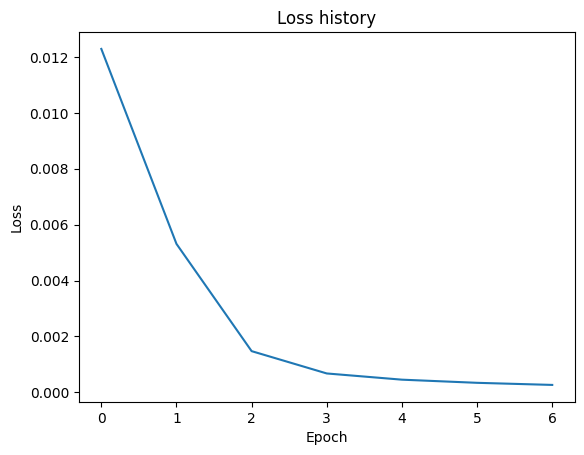

In [14]:
import matplotlib.pyplot as plt
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

In [15]:
# Configure hyper-parameters
epochs = 20
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [16]:
# Now train the injector using non-reschedulable tasks
SC_LSTM.train_model(mode='injector')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()

    for i, (X, task_type, Y) in enumerate(tqdm(train_non_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

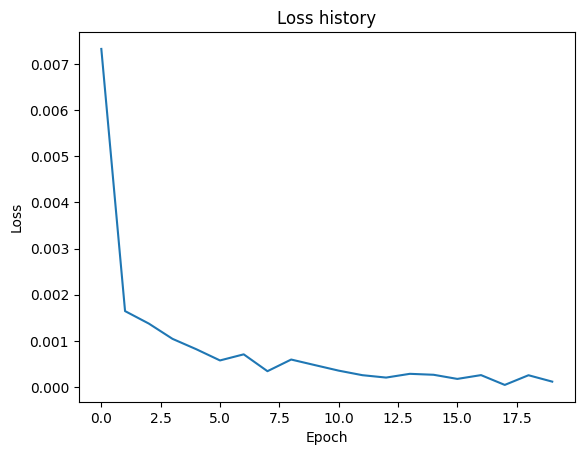

In [17]:
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

# Save weights

In [18]:
torch.save(SC_LSTM.state_dict(), "sc_lstm_weights.pth")